In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


In [5]:
# conversions
veh_name_remap = {'combination long-haul truck':'combination long-haul truck',
                  'combination short-haul truck': 'combination short-haul truck',
                  'single-unit short-haul truck': 'single unit short-haul truck',
                 'single-unit long-haul truck': 'single unit long-haul truck',
                  'light commercial truck':  'light commercial truck'}

sut_ct_label = {'combination long-haul truck':'combination truck',
                  'combination short-haul truck': 'combination truck',
                  'single unit short-haul truck': 'single unit truck',
                 'single unit long-haul truck': 'single unit truck'}

hauling_label = {'combination long-haul truck':'long-haul',
                  'combination short-haul truck': 'short-haul',
                  'single unit short-haul truck': 'short-haul',
                 'single unit long-haul truck': 'long-haul'}

MOVES_fuel_lookup = {1: 'Gasoline', 
                    2: 'Diesel',
                    3: 'CNG',
                    5: 'Other',
                    9: 'Electricity'}

VIUS_fuel_lookup = {'Gasoline': 'Gasoline', 
                    'Diesel': 'Diesel',
                    'Compressed natural gas': 'CNG',
                    'Propane': 'Other',
                    'Combination': 'Other',
                    'Liquified natural gas': 'Other',
                    'Alcohol fuels': 'Other',
                    'Electricity': 'Electricity'}
regclass_lookup = {30:'LDT', 41:'LHD2b3', 
                   42:'LHD45', 46:'MHD67',
                   47:'HHD8 (w. glider)', 
                   49:'HHD8 (w. glider)'}


#age bin related
age_bin = [-1, 3, 5, 7, 9, 14, 19, 31]

age_bin_label = ['age<=3', '3<age<=5','5<age<=7', 
                 '7<age<=9', '9<age<=14', '14<age<=19', 'age>=20']

age_bin_order = {'age<=3':1, '3<age<=5':2, '5<age<=7':3, 
                 '7<age<=9':4, '9<age<=14':5, 
                 '14<age<=19':6, 'age>=20':7}

order_of_col =  ['light commercial truck', 
                 'single unit short-haul truck',
                 'single unit long-haul truck', 
                 'combination short-haul truck',
                 'combination long-haul truck']  

order_of_reg = ['LDT', 'LHD2b3', 'LHD45', 'MHD67', 'HHD8 (w. glider)']

In [6]:
# load MOVES data
MOVES_data_path = 'RawData/MOVES/MOVES_VMT_fraction_with_fuel_com_only.csv'
MOVES_fleet = read_csv(MOVES_data_path)
print(MOVES_fleet.columns)

# load vius data
vius_data_path = 'RawData/US_VIUS_2021/vius_2021_com_crosswalk_20240419.csv'
vius_fleet = read_csv(vius_data_path)
vius_fleet.head(5)

# additional distribution data
regclass_distribution = pd.read_excel('RawData/MOVES/moves_definition.xlsx', 
                                      sheet_name = 'fuel_type_distribution')
regclass_distribution.head(5)

Index(['sourceTypeID', 'ageID', 'HPMSVtypeID', 'sourceTypeName',
       'HPMSVtypeName', 'sourceTypePopulation', 'ageFraction', 'modelYearID',
       'population_by_year', 'relativeMAR', 'weighted_vmt_rate',
       'vmt_fraction', 'fuelTypeID', 'stmyFraction', 'fuelTypeDesc'],
      dtype='object')


,sourceTypeModelYearID,sourceTypeID,modelYearID,fuelTypeID,engTechID,regClassID,stmyFuelEngFraction,stmyFraction
0,111960,11,1960,1,1,10,1.0,1.0
1,111961,11,1961,1,1,10,1.0,1.0
2,111962,11,1962,1,1,10,1.0,1.0
3,111963,11,1963,1,1,10,1.0,1.0
4,111964,11,1964,1,1,10,1.0,1.0


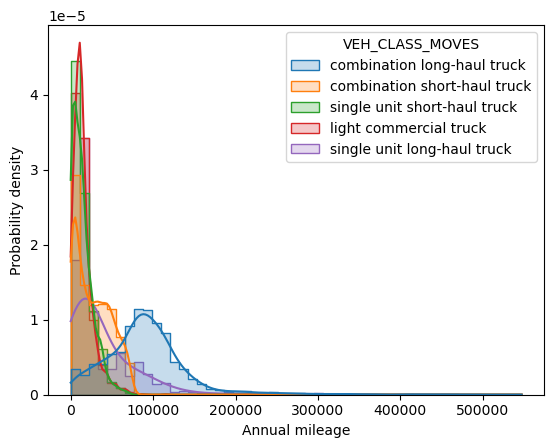

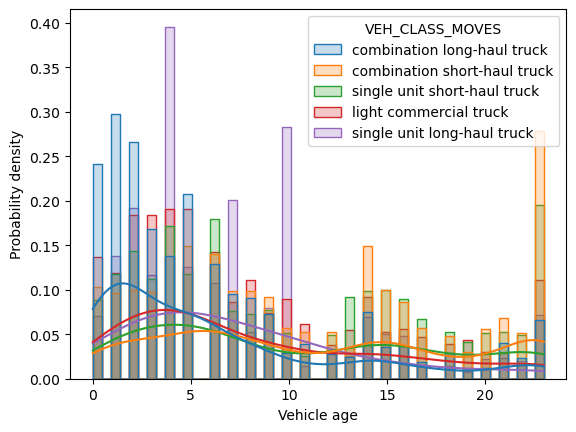

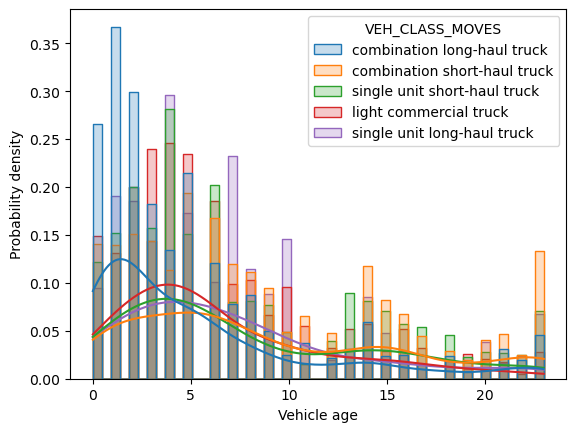

In [7]:
# post-process VIUS and MOVES data

# weighted VMT
vius_fleet.loc[:, 'WGT_VMT'] = \
vius_fleet.loc[:, 'TABWEIGHT'] * vius_fleet.loc[:, 'MILESANNL']

# vehicle age
vius_fleet.loc[:, 'VEH_AGE'] = \
2021 - vius_fleet.loc[:, 'MODELYEAR']

vius_fleet.loc[:, 'AGE_BIN'] = \
pd.cut(vius_fleet.loc[:, 'VEH_AGE'], 
       bins=age_bin, right=True, labels=age_bin_label)

vius_fleet['VEH_CLASS_MOVES'] = \
vius_fleet['VEH_CLASS_MOVES'].str.lower()
vius_fleet.loc[:, 'VEH_CLASS_MOVES'] = \
vius_fleet.loc[:, 'VEH_CLASS_MOVES'].map(veh_name_remap)

MOVES_fleet.loc[:, 'AGE_BIN'] = \
pd.cut(MOVES_fleet.loc[:, 'ageID'], 
       bins=age_bin, right=True, labels=age_bin_label)

MOVES_fleet['sourceTypeName'] = \
MOVES_fleet['sourceTypeName'].str.lower()

sns.histplot(data=vius_fleet, 
             x="MILESANNL", weights = 'TABWEIGHT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Annual mileage')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/annual_mileage_VIUS.png', dpi = 300)
plt.show()

sns.histplot(data=vius_fleet, 
             x="VEH_AGE", weights = 'TABWEIGHT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Vehicle age')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/age_distribution_by_count_VIUS.png', dpi = 300)
plt.show()

sns.histplot(data=vius_fleet, 
             x="VEH_AGE", weights = 'WGT_VMT',
             stat = 'density', 
             hue="VEH_CLASS_MOVES", element="step",
             bins = 50, kde = True,
             common_norm = False)
plt.xlabel('Vehicle age')
plt.ylabel('Probability density')
plt.savefig('RawData/MOVES/plot/age_distribution_by_VMT_VIUS.png', dpi = 300)
plt.show()

In [8]:
# assign regulatory class 
# assign regular class to VIUS data
vius_fleet.loc[:, 'regClassID'] = 0
# LDT
vius_fleet.loc[vius_fleet['GVWR_CLASS'].isin(['1', '2A']), 'regClassID'] = 30
# LHD2B3
vius_fleet.loc[vius_fleet['GVWR_CLASS'].isin(['2B', '3']), 'regClassID'] = 41
# LHD45
vius_fleet.loc[vius_fleet['GVWR_CLASS'].isin(['4', '5']), 'regClassID'] = 42
# MHD67
vius_fleet.loc[vius_fleet['GVWR_CLASS'].isin(['6', '7']), 'regClassID'] = 46
# HHD8 (including glider)
vius_fleet.loc[vius_fleet['GVWR_CLASS'].isin(['8']), 'regClassID'] = 47
print(vius_fleet.regClassID.unique())

[47 46 42 41 30]


In [9]:
# add regular class to MOVES results
regclass_distribution = \
regclass_distribution[['sourceTypeID', 'modelYearID', 'fuelTypeID',	'regClassID', 'stmyFuelEngFraction']]
regclass_distribution = regclass_distribution.drop_duplicates(keep = 'first')
MOVES_fleet = pd.merge(MOVES_fleet, regclass_distribution,
                      on = ['sourceTypeID', 'modelYearID', 'fuelTypeID'],
                      how = 'left')
MOVES_fleet.loc[:, 'population_by_year_class'] = MOVES_fleet.loc[:, 'population_by_year'] * \
MOVES_fleet.loc[:, 'stmyFuelEngFraction'] * MOVES_fleet.loc[:, 'stmyFraction']

MOVES_fleet.loc[:, 'vmt_fraction'] = MOVES_fleet.loc[:, 'vmt_fraction'] * \
MOVES_fleet.loc[:, 'stmyFuelEngFraction']

MOVES_fleet.head(5)

,sourceTypeID,ageID,HPMSVtypeID,sourceTypeName,HPMSVtypeName,sourceTypePopulation,ageFraction,modelYearID,population_by_year,relativeMAR,weighted_vmt_rate,vmt_fraction,fuelTypeID,stmyFraction,fuelTypeDesc,AGE_BIN,regClassID,stmyFuelEngFraction,population_by_year_class
0,32,0,25,light commercial truck,Light Duty Vehicles,14895684,0.059197,2021,881778.627797,1.0,881778.627797,0.034848,1,0.778959,Gasoline,age<=3,30,0.830981,570775.927187
1,32,0,25,light commercial truck,Light Duty Vehicles,14895684,0.059197,2021,881778.627797,1.0,881778.627797,0.007088,1,0.778959,Gasoline,age<=3,41,0.169019,116093.738790
2,32,0,25,light commercial truck,Light Duty Vehicles,14895684,0.059197,2021,881778.627797,1.0,881778.627797,0.000105,2,0.061317,Diesel Fuel,age<=3,30,0.031932,1726.517006
3,32,0,25,light commercial truck,Light Duty Vehicles,14895684,0.059197,2021,881778.627797,1.0,881778.627797,0.003196,2,0.061317,Diesel Fuel,age<=3,41,0.968068,52341.771557
4,32,0,25,light commercial truck,Light Duty Vehicles,14895684,0.059197,2021,881778.627797,1.0,881778.627797,0.008383,5,0.155723,Ethanol (E-85),age<=3,30,1.000000,137313.558746


In [10]:
MOVES_fleet.loc[:, 'regClassName'] = \
MOVES_fleet.loc[:, 'regClassID'].map(regclass_lookup)

print(MOVES_fleet.loc[:, 'regClassName'].unique())

vius_fleet.loc[:, 'regClassName'] = \
vius_fleet.loc[:, 'regClassID'].map(regclass_lookup)

print(vius_fleet.loc[:, 'regClassName'].unique())

['LDT' 'LHD2b3' 'LHD45' 'MHD67' 'HHD8 (w. glider)']
['HHD8 (w. glider)' 'MHD67' 'LHD45' 'LHD2b3' 'LDT']


# Part 0 - collecting fleet distribution from VIUS

In [11]:
# collect truck count by state
vius_fleet_by_state = pd.pivot_table(vius_fleet,
                                     index = 'REGSTATE',
                                     columns = 'GVWR_CLASS',
                                     values = 'TABWEIGHT',
                                     aggfunc = 'sum')
vius_fleet_by_state = vius_fleet_by_state.reset_index()
vius_fleet_by_state.to_csv('RawData/US_VIUS_2021/VIUS_truck_count_by_state.csv',
                          index = False)
vius_fleet_by_state.head(5)

GVWR_CLASS,REGSTATE,1,2A,2B,3,4,5,6,7,8
0,Alabama,121494.4,198457.9,23742.5,23070.4,4819.1,6892.3,8806.8,6885.1,36184.3
1,Alaska,18779.2,26052.5,14555.4,2988.4,1434.2,2238.5,1209.4,1312.5,6659.6
2,Arizona,140747.3,194854.2,95034.7,10616.3,3480.8,7777.0,4505.0,7529.0,41624.2
3,Arkansas,38894.9,136245.0,22651.8,19526.3,6765.9,3741.1,4447.9,4643.1,29914.1
4,California,1891528.0,1426343.6,219701.9,196076.9,43826.5,77942.3,75591.5,30633.0,268850.6


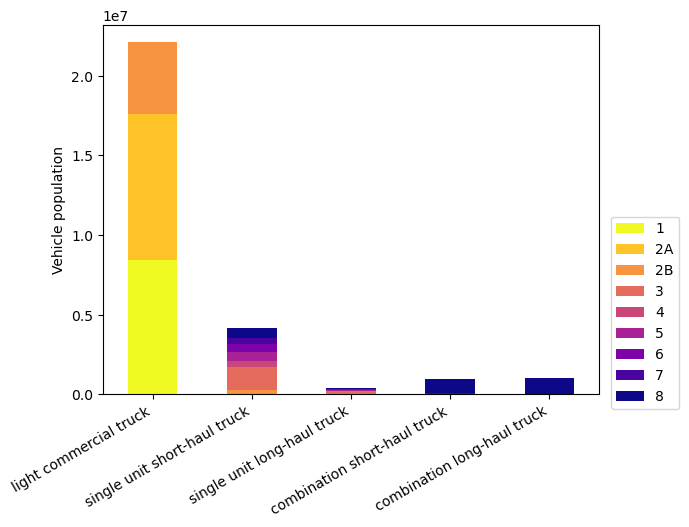

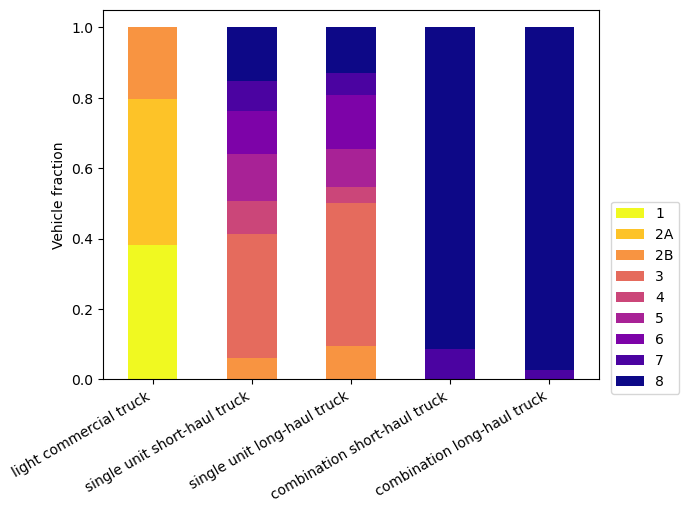

In [12]:
# additional cross-tab for VIUS

vius_fleet_by_class = pd.pivot_table(vius_fleet,
                                     index = 'VEH_CLASS_MOVES',
                                     columns = 'GVWR_CLASS',
                                     values = 'TABWEIGHT',
                                     aggfunc = 'sum')
vius_fleet_by_class = vius_fleet_by_class.fillna(0)
vius_fleet_by_class = vius_fleet_by_class.loc[order_of_col]
vius_fleet_by_class.plot(kind = 'bar', stacked = True, cmap= 'plasma_r')
plt.xticks(rotation = 30, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.5))
plt.ylabel('Vehicle population')
plt.xlabel('')
plt.show()
vius_fleet_by_class_frac = vius_fleet_by_class.copy()
class_label = vius_fleet.GVWR_CLASS.unique()
vius_fleet_by_class_frac.loc[:, class_label] = \
    vius_fleet_by_class_frac.loc[:, class_label].div(vius_fleet_by_class_frac.loc[:, class_label].sum(axis=1), axis=0)

vius_fleet_by_class_frac.plot(kind = 'bar', stacked = True, cmap= 'plasma_r')
plt.xticks(rotation = 30, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.5))
plt.ylabel('Vehicle fraction')
plt.xlabel('')
plt.show()

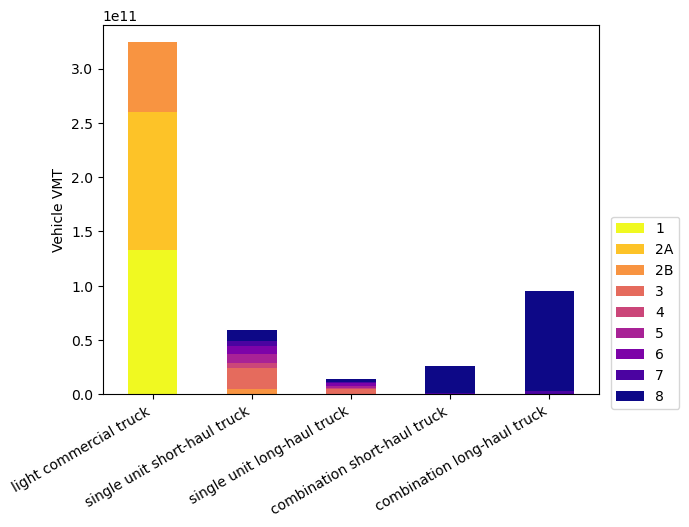

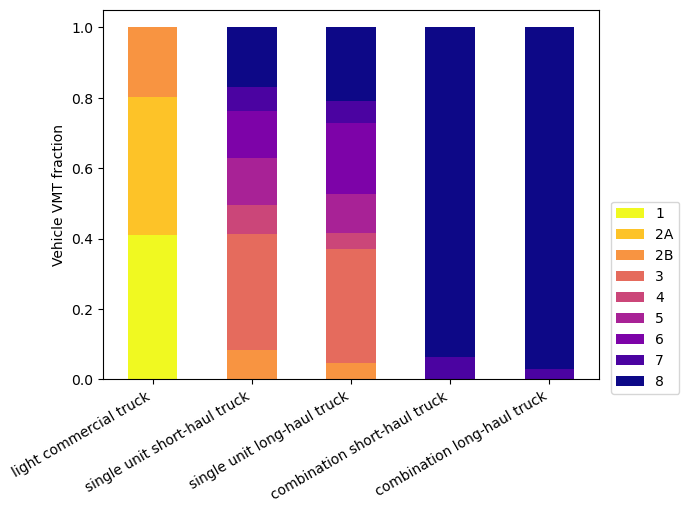

In [13]:
# additional cross-tab for VIUS by VMT

vius_fleet_by_class = pd.pivot_table(vius_fleet,
                                     index = 'VEH_CLASS_MOVES',
                                     columns = 'GVWR_CLASS',
                                     values = 'WGT_VMT',
                                     aggfunc = 'sum')
vius_fleet_by_class = vius_fleet_by_class.fillna(0)
vius_fleet_by_class = vius_fleet_by_class.loc[order_of_col]
vius_fleet_by_class.plot(kind = 'bar', stacked = True, cmap= 'plasma_r')
plt.xticks(rotation = 30, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.5))
plt.ylabel('Vehicle VMT')
plt.xlabel('')
plt.show()
vius_fleet_by_class_frac = vius_fleet_by_class.copy()
class_label = vius_fleet.GVWR_CLASS.unique()
vius_fleet_by_class_frac.loc[:, class_label] = \
    vius_fleet_by_class_frac.loc[:, class_label].div(vius_fleet_by_class_frac.loc[:, class_label].sum(axis=1), axis=0)

vius_fleet_by_class_frac.plot(kind = 'bar', stacked = True, cmap= 'plasma_r')
plt.xticks(rotation = 30, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.5))
plt.ylabel('Vehicle VMT fraction')
plt.xlabel('')
plt.show()

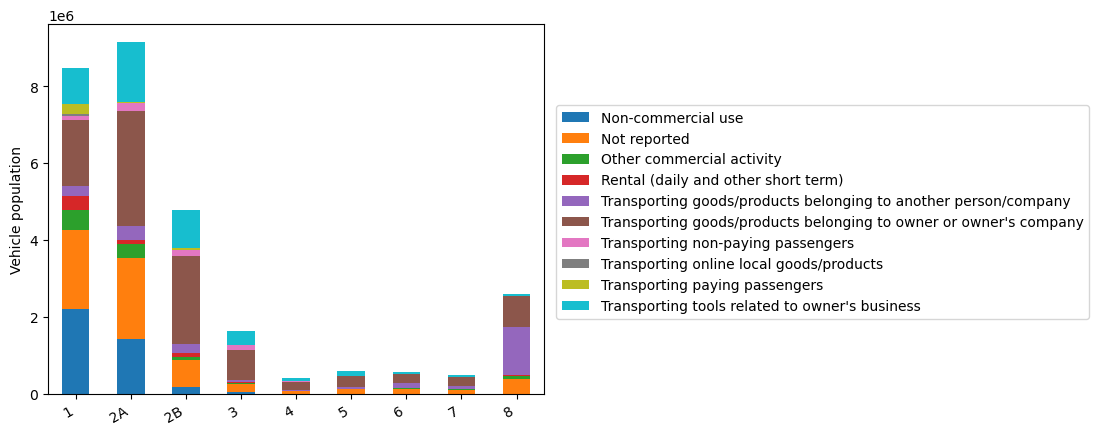

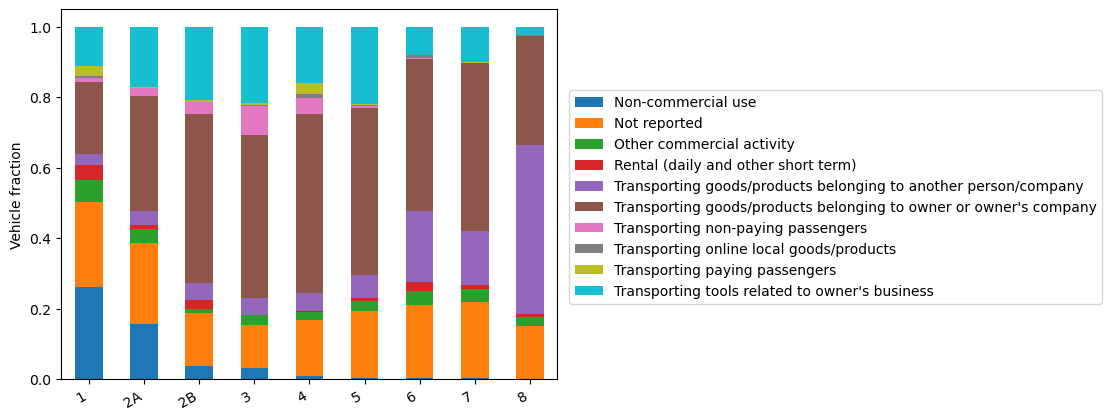

In [14]:
# Primary use
vius_fleet_by_use = pd.pivot_table(vius_fleet,
                                     index = 'GVWR_CLASS',
                                     columns = 'PRIMCOMMACT',
                                     values = 'TABWEIGHT',
                                     aggfunc = 'sum')
vius_fleet_by_use = vius_fleet_by_use.fillna(0)
# vius_fleet_by_use = vius_fleet_by_use.loc[order_of_col]
vius_fleet_by_use.plot(kind = 'bar', stacked = True)
plt.xticks(rotation = 30, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.8))
plt.ylabel('Vehicle population')
plt.xlabel('')
plt.show()
vius_fleet_by_use_frac = vius_fleet_by_use.copy()
use_label = vius_fleet.PRIMCOMMACT.unique()
vius_fleet_by_use_frac.loc[:, use_label] = \
    vius_fleet_by_use_frac.loc[:, use_label].div(vius_fleet_by_use_frac.loc[:, use_label].sum(axis=1), axis=0)

vius_fleet_by_use_frac.plot(kind = 'bar', stacked = True)
plt.xticks(rotation = 30, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.8))
plt.ylabel('Vehicle fraction')
plt.xlabel('')
plt.show()

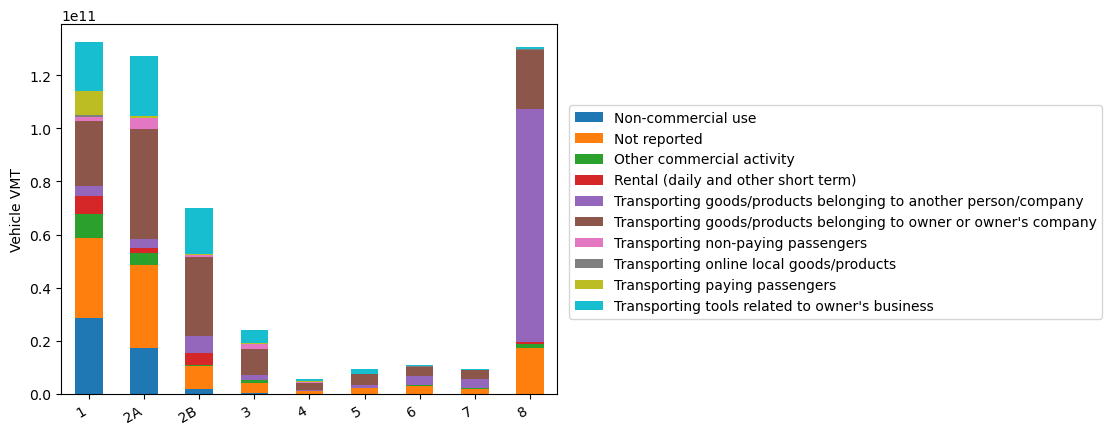

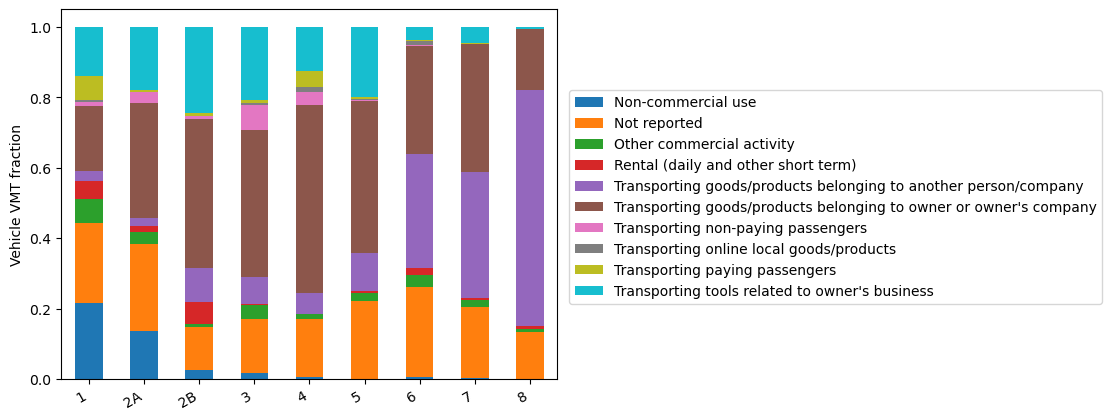

In [15]:
# Primary use by VMT

vius_fleet_by_use = pd.pivot_table(vius_fleet,
                                     index = 'GVWR_CLASS',
                                     columns = 'PRIMCOMMACT',
                                     values = 'WGT_VMT',
                                     aggfunc = 'sum')
vius_fleet_by_use = vius_fleet_by_use.fillna(0)
# vius_fleet_by_use = vius_fleet_by_use.loc[order_of_col]
vius_fleet_by_use.plot(kind = 'bar', stacked = True)
plt.xticks(rotation = 30, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.8))
plt.ylabel('Vehicle VMT')
plt.xlabel('')
plt.show()
vius_fleet_by_use_frac = vius_fleet_by_use.copy()
use_label = vius_fleet.PRIMCOMMACT.unique()
vius_fleet_by_use_frac.loc[:, use_label] = \
    vius_fleet_by_use_frac.loc[:, use_label].div(vius_fleet_by_use_frac.loc[:, use_label].sum(axis=1), axis=0)

vius_fleet_by_use_frac.plot(kind = 'bar', stacked = True)
plt.xticks(rotation = 30, ha = 'right')
plt.legend(bbox_to_anchor = (1.01, 0.8))
plt.ylabel('Vehicle VMT fraction')
plt.xlabel('')
plt.show()

In [16]:
# create cross-tab for major usage
use_label_sel = ["Transporting goods/products belonging to owner or owner's company",
       'Transporting goods/products belonging to another person/company',
                'Transporting online local goods/products']

vius_fleet_freight = vius_fleet.loc[vius_fleet['PRIMCOMMACT'].isin(use_label_sel)]
vius_fleet_freight_ca = \
vius_fleet_freight.loc[vius_fleet_freight['REGSTATE'] == 'California']


vius_fleet_by_use = pd.pivot_table(vius_fleet_freight,
                                     index = 'PRIMCOMMACT',
                                     columns = 'GVWR_CLASS',
                                     values = 'TABWEIGHT',
                                     aggfunc = 'sum')
vius_fleet_by_use.loc[:, 'region'] = 'US'
vius_fleet_by_use_ca = pd.pivot_table(vius_fleet_freight_ca,
                                     index = 'PRIMCOMMACT',
                                     columns = 'GVWR_CLASS',
                                     values = 'TABWEIGHT',
                                     aggfunc = 'sum')
vius_fleet_by_use_ca.loc[:, 'region'] = 'CA'

vius_fleet_by_use_ca_comb = pd.concat([vius_fleet_by_use, 
                                       vius_fleet_by_use_ca])
vius_fleet_by_use_ca_comb.fillna(0, inplace = True)
vius_fleet_by_use_ca_comb.to_csv('RawData/US_VIUS_2021/vius_use_and_class_by_count.csv')

# create cross-tab for major usage, agg by VMT

vius_fleet_by_use = pd.pivot_table(vius_fleet_freight,
                                     index = 'PRIMCOMMACT',
                                     columns = 'GVWR_CLASS',
                                     values = 'WGT_VMT',
                                     aggfunc = 'sum')
vius_fleet_by_use.loc[:, 'region'] = 'US'
vius_fleet_by_use_ca = pd.pivot_table(vius_fleet_freight_ca,
                                     index = 'PRIMCOMMACT',
                                     columns = 'GVWR_CLASS',
                                     values = 'WGT_VMT',
                                     aggfunc = 'sum')
vius_fleet_by_use_ca.loc[:, 'region'] = 'CA'

vius_fleet_by_use_ca_comb = pd.concat([vius_fleet_by_use, 
                                       vius_fleet_by_use_ca])
vius_fleet_by_use_ca_comb.fillna(0, inplace = True)
vius_fleet_by_use_ca_comb.to_csv('RawData/US_VIUS_2021/vius_use_and_class_by_VMT.csv')

In [10]:
vius_fleet_freight.groupby(['PRIMCOMMACT']).size()

PRIMCOMMACT
Transporting goods/products belonging to another person/company       9022
Transporting goods/products belonging to owner or owner's company    15785
Transporting online local goods/products                               156
dtype: int64

In [5]:
# check sample size
vius_sample_size_1 = vius_fleet.groupby(['VEH_CLASS_MOVES']).size()
print(vius_sample_size_1)

vius_sample_size_2 = vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN']).size()
# vius_sample_size_2

vius_sample_size_3 = vius_fleet.groupby(['VEH_CLASS_MOVES'])['TABWEIGHT'].sum()
print(vius_sample_size_3)

VEH_CLASS_MOVES
Combination long-haul truck      6100
Combination short-haul truck     6513
Light commercial truck           2934
Single-unit long-haul truck      1546
Single-unit short-haul truck    19887
dtype: int64
VEH_CLASS_MOVES
Combination long-haul truck      1057993.1
Combination short-haul truck      968638.8
Light commercial truck          22094830.1
Single-unit long-haul truck       392897.9
Single-unit short-haul truck     4177755.3
Name: TABWEIGHT, dtype: float64


In [17]:
# plot func
def plot_clustered_stacked(dfall, labels, title, ylabelname, H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""
    plt.figure(figsize = (6, 5))
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False, cmap= 'plasma_r',
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i * 2))

    l1 = axe.legend(h[:n_col], l[:n_col], 
                    bbox_to_anchor=(0.99, 1), loc="upper left", fontsize = 7)
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    plt.xticks(rotation = 60, ha = 'right')
    plt.ylabel(ylabelname)
    plt.xlabel('')
    plt.tight_layout()
    
    return axe

# Part 1.1 - truck count comparison and hauling fraction

In [18]:
# compare veh count by MOVES source type

# MOVES_fleet.head(5)
MOVES_count_by_st = \
MOVES_fleet.groupby('sourceTypeName')[['sourceTypePopulation']].mean()
MOVES_count_by_st = MOVES_count_by_st.reset_index()

print(MOVES_count_by_st['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_st = \
vius_fleet.groupby('VEH_CLASS_MOVES')[['TABWEIGHT']].sum()
vius_count_by_st = vius_count_by_st.reset_index()

# generate veh count comparison
MOVES_count_by_st.columns = ['Vehicle type', 'Count']
MOVES_count_by_st.loc[:, 'Source'] = 'MOVES'

vius_count_by_st.columns = ['Vehicle type', 'Count']
vius_count_by_st.loc[:, 'Source'] = '2021 US VIUS'

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


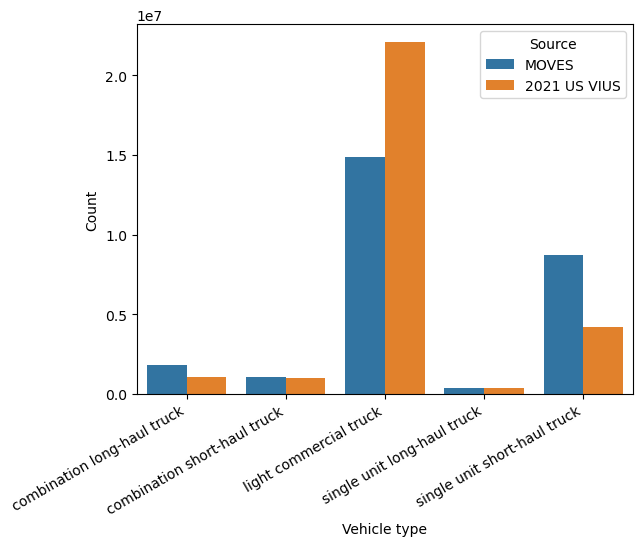

In [19]:
truck_count_comparison = \
pd.concat([MOVES_count_by_st, vius_count_by_st])
sns.barplot(truck_count_comparison, 
            x="Vehicle type", y="Count", hue="Source", 
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

In [20]:
truck_count_comparison.to_csv('RawData/MOVES/MOVES_VIUS_truck_count.csv', index = False)

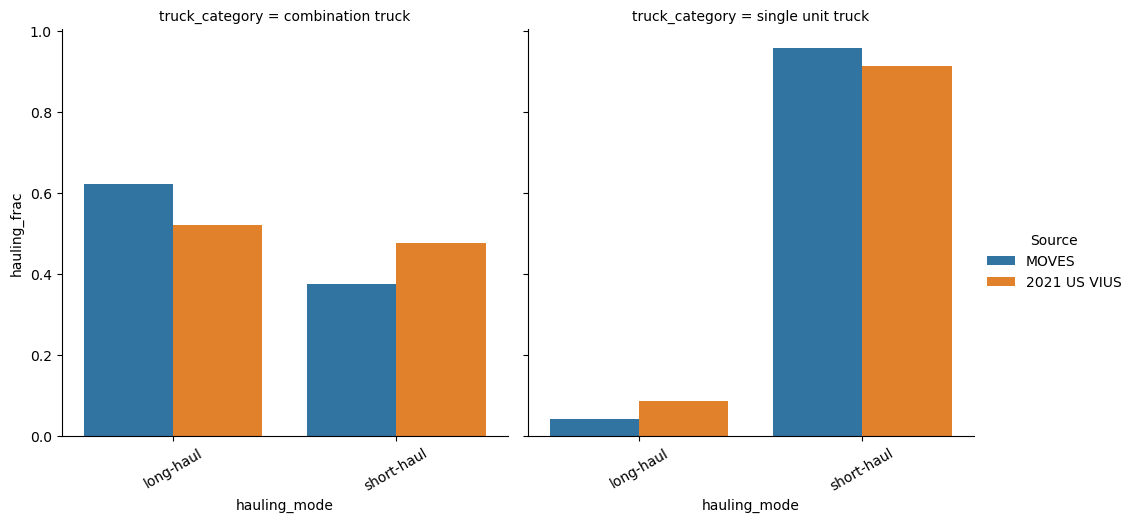

,Vehicle type,Count,Source,truck_category,hauling_mode,hauling_frac
0,combination long-haul truck,1811108.0,MOVES,combination truck,long-haul,0.623996
1,combination short-haul truck,1091325.0,MOVES,combination truck,short-haul,0.376004
3,single unit long-haul truck,383855.0,MOVES,single unit truck,long-haul,0.042241
4,single unit short-haul truck,8703350.0,MOVES,single unit truck,short-haul,0.957759
0,combination long-haul truck,1057993.1,2021 US VIUS,combination truck,long-haul,0.522045
1,combination short-haul truck,968638.8,2021 US VIUS,combination truck,short-haul,0.477955
3,single unit long-haul truck,392897.9,2021 US VIUS,single unit truck,long-haul,0.085961
4,single unit short-haul truck,4177755.3,2021 US VIUS,single unit truck,short-haul,0.914039


In [21]:
# hauling fraction by category

# drop LDT
truck_count_comparison = \
truck_count_comparison.loc[truck_count_comparison["Vehicle type"] != 
'light commercial truck']
truck_count_comparison.loc[:, 'truck_category'] =\
truck_count_comparison.loc[:, 'Vehicle type'].map(sut_ct_label)
truck_count_comparison.loc[:, 'hauling_mode'] =\
truck_count_comparison.loc[:, 'Vehicle type'].map(hauling_label)

truck_count_comparison.loc[:, 'hauling_frac'] = \
truck_count_comparison.loc[:, 'Count'] /\
truck_count_comparison.groupby(['Source', 'truck_category'])['Count'].transform('sum')

ax = sns.catplot(truck_count_comparison, 
            x="hauling_mode", y="hauling_frac", 
            hue="Source", col = 'truck_category', kind = 'bar',
            errorbar = None)
# plt.xticks(rotation = 30, ha= 'right')
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
plt.savefig('RawData/MOVES/plot/truck_hauling_frac_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()
truck_count_comparison

# Part 1.2 - truck VMT comparison and hauling fraction

In [27]:
# compare veh VMT by MOVES source type

# MOVES_fleet.head(5)
MOVES_VMT_by_st = \
MOVES_fleet.groupby('sourceTypeName')[['vmt_fraction']].sum()
MOVES_VMT_by_st = MOVES_VMT_by_st.reset_index()
print(MOVES_VMT_by_st['sourceTypeName'].unique())

# MOVES_count_by_st

vius_VMT_by_st = \
vius_fleet.groupby('VEH_CLASS_MOVES')[['WGT_VMT']].sum()
vius_VMT_by_st = vius_VMT_by_st.reset_index()

# generate veh count comparison
MOVES_VMT_by_st.columns = ['Vehicle type', 'VMT rate']
MOVES_VMT_by_st.loc[:, 'Source'] = 'MOVES'

vius_VMT_by_st.columns = ['Vehicle type', 'VMT rate']
vius_VMT_by_st.loc[:, 'Source'] = '2021 US VIUS'

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


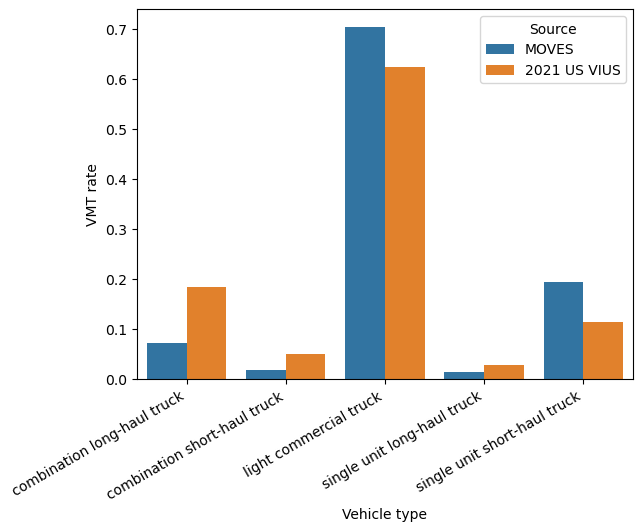

In [28]:
truck_VMT_comparison = \
pd.concat([MOVES_VMT_by_st, vius_VMT_by_st])
truck_VMT_comparison.loc[:, 'VMT rate'] = \
truck_VMT_comparison.loc[:, 'VMT rate'] /\
truck_VMT_comparison.groupby(['Source'])['VMT rate'].transform('sum')
truck_VMT_comparison.head(10)

sns.barplot(truck_VMT_comparison, 
            x="Vehicle type", y="VMT rate", hue="Source", 
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_VMT_comparison_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

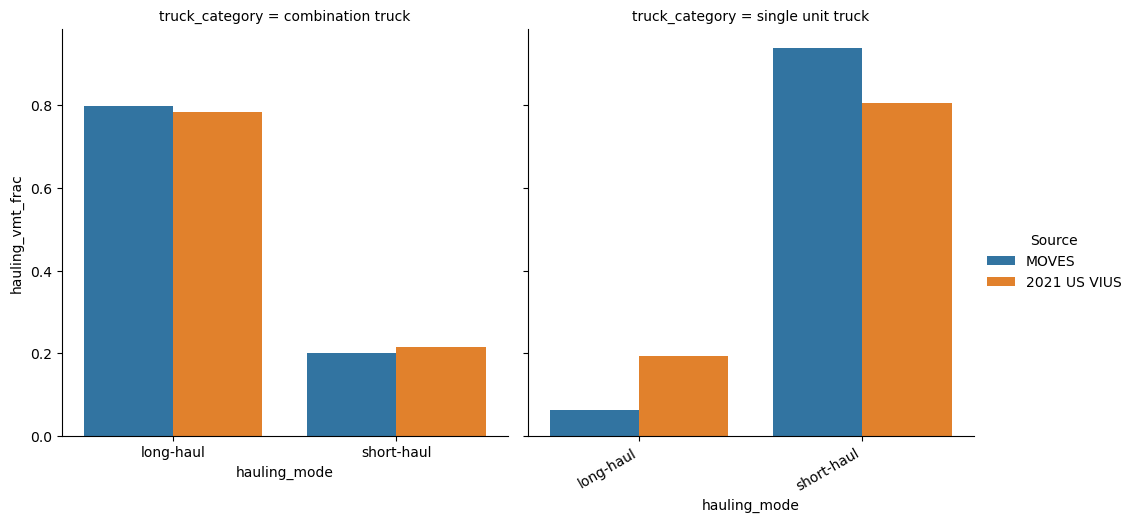

,Vehicle type,VMT rate,Source,truck_category,hauling_mode,hauling_vmt_frac
0,combination long-haul truck,7.223619e-02,MOVES,combination truck,long-haul,0.798135
1,combination short-haul truck,1.827009e-02,MOVES,combination truck,short-haul,0.201865
3,single unit long-haul truck,1.286725e-02,MOVES,single unit truck,long-haul,0.062540
4,single unit short-haul truck,1.928769e-01,MOVES,single unit truck,short-haul,0.937460
0,combination long-haul truck,9.567150e+10,2021 US VIUS,combination truck,long-haul,0.784705
1,combination short-haul truck,2.624889e+10,2021 US VIUS,combination truck,short-haul,0.215295
3,single unit long-haul truck,1.427704e+10,2021 US VIUS,single unit truck,long-haul,0.195017
4,single unit short-haul truck,5.893217e+10,2021 US VIUS,single unit truck,short-haul,0.804983


In [29]:
# hauling VMT fraction by category
truck_VMT_comparison = \
pd.concat([MOVES_VMT_by_st, vius_VMT_by_st])
truck_VMT_comparison = \
truck_VMT_comparison.loc[truck_VMT_comparison["Vehicle type"] != 
'light commercial truck']
truck_VMT_comparison.loc[:, 'truck_category'] =\
truck_VMT_comparison.loc[:, 'Vehicle type'].map(sut_ct_label)
truck_VMT_comparison.loc[:, 'hauling_mode'] =\
truck_VMT_comparison.loc[:, 'Vehicle type'].map(hauling_label)

truck_VMT_comparison.loc[:, 'hauling_vmt_frac'] = \
truck_VMT_comparison.loc[:, 'VMT rate'] /\
truck_VMT_comparison.groupby(['Source', 'truck_category'])['VMT rate'].transform('sum')

sns.catplot(truck_VMT_comparison, 
            x="hauling_mode", y="hauling_vmt_frac", 
            hue="Source", col = 'truck_category', kind = 'bar',
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_hauling_vmt_frac_by_type.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()
truck_VMT_comparison

# Part 2.1 - truck type and age distribution by count

In [30]:
# compare veh count by MOVES source type and age bin

MOVES_count_by_st_age = \
MOVES_fleet.groupby(['sourceTypeName', 'AGE_BIN'])[['population_by_year_class']].sum()
MOVES_count_by_st_age = MOVES_count_by_st_age.reset_index()
print(MOVES_count_by_st_age['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_st_age = \
vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN'])[['TABWEIGHT']].sum()
vius_count_by_st_age = vius_count_by_st_age.reset_index()

# generate veh count comparison
MOVES_count_by_st_age.columns = ['Vehicle type', 'Age bin', 'Fraction']
MOVES_count_by_st_age.loc[:, 'Source'] = 'MOVES'
MOVES_count_by_st_age.loc[:, 'Fraction'] = \
MOVES_count_by_st_age.loc[:, 'Fraction']/ \
MOVES_count_by_st_age.groupby('Vehicle type')['Fraction'].transform('sum')

vius_count_by_st_age.columns = ['Vehicle type', 'Age bin', 'Fraction']
vius_count_by_st_age.loc[:, 'Source'] = '2021 US VIUS'
vius_count_by_st_age.loc[:, 'Fraction'] = \
vius_count_by_st_age.loc[:, 'Fraction']/ \
vius_count_by_st_age.groupby('Vehicle type')['Fraction'].transform('sum')

vius_count_by_st_age.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


,Vehicle type,Age bin,Fraction,Source
0,combination long-haul truck,14<age<=19,0.059992,2021 US VIUS
1,combination long-haul truck,3<age<=5,0.158874,2021 US VIUS
2,combination long-haul truck,5<age<=7,0.102819,2021 US VIUS
3,combination long-haul truck,7<age<=9,0.075193,2021 US VIUS
4,combination long-haul truck,9<age<=14,0.089670,2021 US VIUS


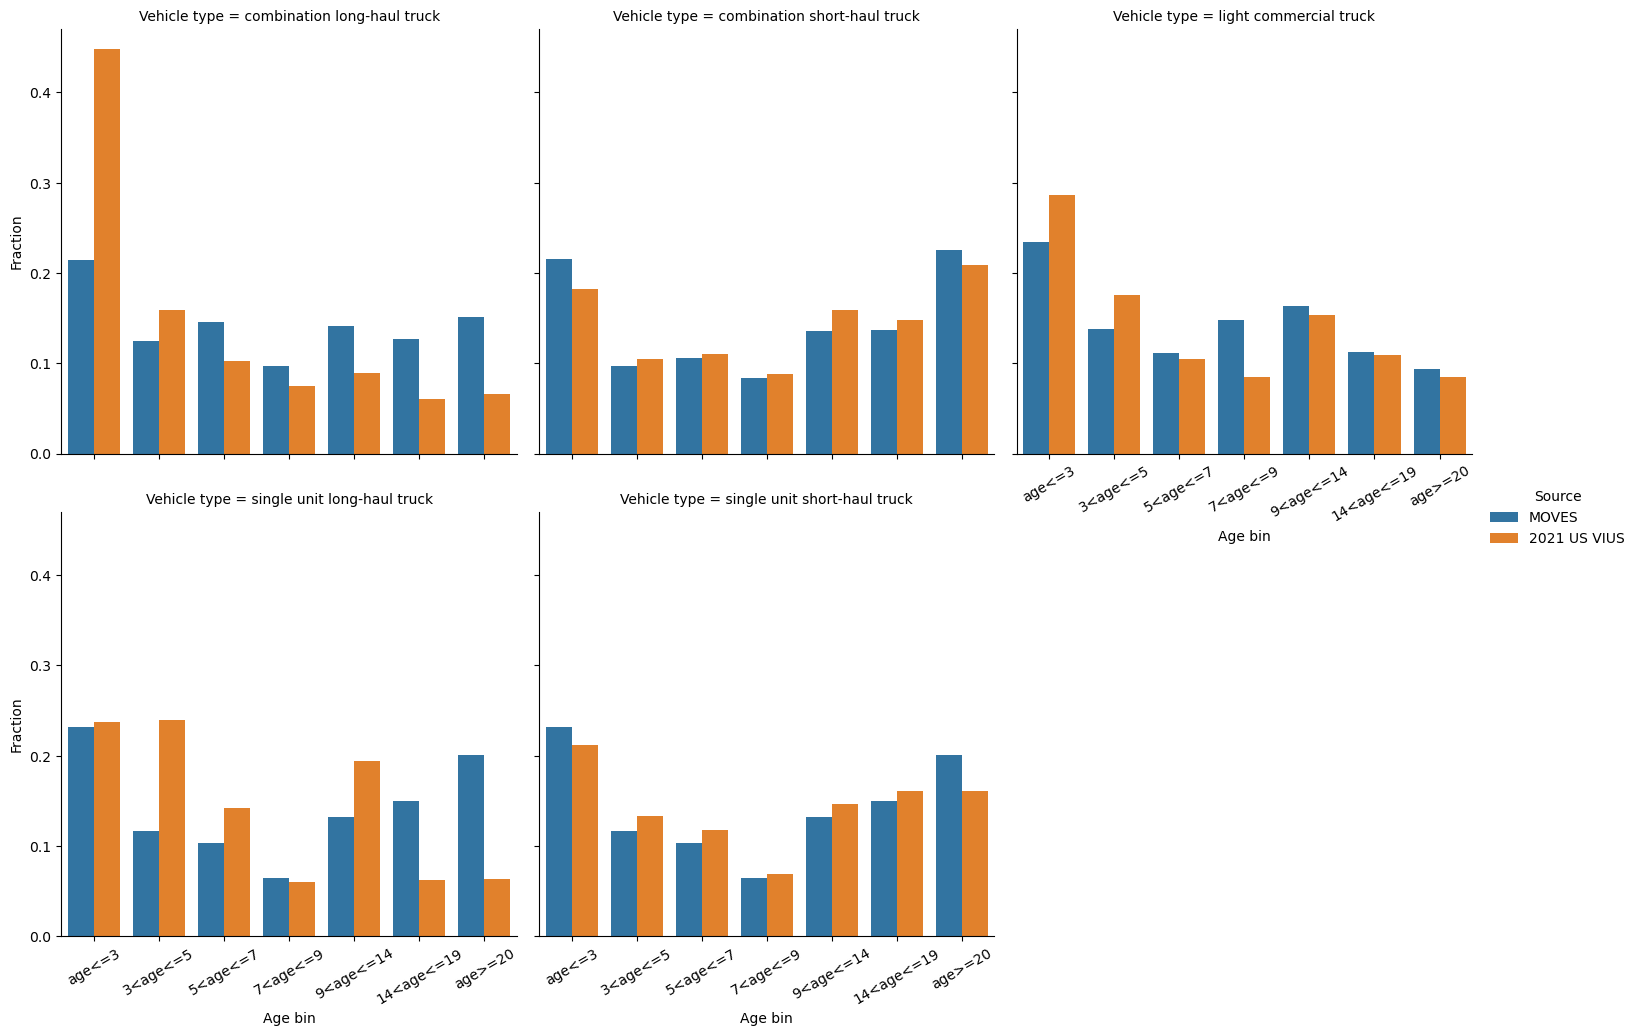

In [31]:
#plot age distribution
truck_count_comparison_by_age = \
pd.concat([MOVES_count_by_st_age, vius_count_by_st_age])

g = sns.catplot(truck_count_comparison_by_age, 
            x="Age bin", y="Fraction", hue="Source", 
            kind = 'bar', col = 'Vehicle type',
            col_wrap = 3)
for axn in g.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
# g.set_xticklabels(rotation = 30, ha= 'right')
plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_age.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

In [32]:
# plot ST MY distribution
# MOVES_fleet.head(5)
MOVES_fleet_selected = \
MOVES_fleet[['sourceTypeName', 'ageID', 'AGE_BIN', 'fuelTypeID', 'regClassID', 'population_by_year_class']]
MOVES_fleet_selected = MOVES_fleet_selected.drop_duplicates(keep = 'first')


MOVES_count_by_stmy = pd.pivot_table(MOVES_fleet_selected, index = 'sourceTypeName',
                                  columns = 'AGE_BIN', values = 'population_by_year_class',
                                  aggfunc = 'sum')

MOVES_count_by_stmy = MOVES_count_by_stmy.reset_index()
print(MOVES_count_by_stmy['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_stmy = pd.pivot_table(vius_fleet, index = 'VEH_CLASS_MOVES',
                                  columns = 'AGE_BIN', values = 'TABWEIGHT',
                                  aggfunc = 'sum')
vius_count_by_stmy = vius_count_by_stmy.reset_index()

vius_count_by_stmy = \
vius_count_by_stmy.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})


vius_count_by_stmy = vius_count_by_stmy.set_index('sourceTypeName')
MOVES_count_by_stmy = MOVES_count_by_stmy.set_index('sourceTypeName')

vius_count_by_stmy.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


AGE_BIN,14<age<=19,3<age<=5,5<age<=7,7<age<=9,9<age<=14,age<=3,age>=20
sourceTypeName,,,,,,,
combination long-haul truck,63471.3,168087.3,108782.3,79554.2,94869.8,473795.9,69432.3
combination short-haul truck,142800.8,100938.4,106501.6,85036.2,154087.9,176792.4,202481.5
light commercial truck,2411724.9,3876145.7,2316821.0,1874471.5,3398892.4,6337619.4,1879155.2
single unit long-haul truck,24634.9,94211.7,55825.7,23812.0,76296.8,93352.5,24764.3
single unit short-haul truck,671298.6,556003.3,491696.2,289863.4,611305.8,887020.5,670567.5


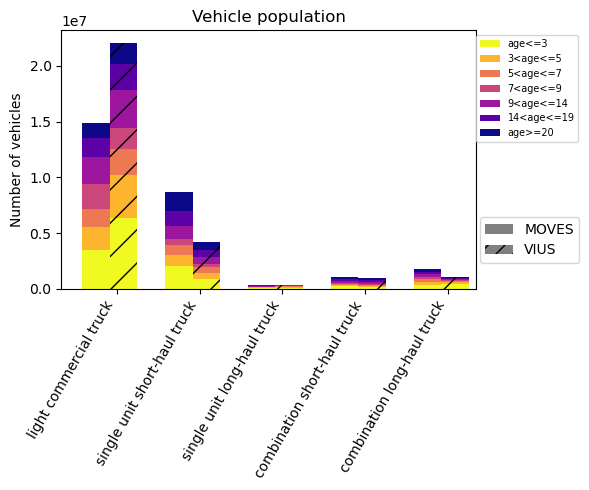

In [33]:
# plot stacked bar chart
vius_count_by_stmy = vius_count_by_stmy[age_bin_label]
vius_count_by_stmy = vius_count_by_stmy.loc[order_of_col]

MOVES_count_by_stmy = MOVES_count_by_stmy[age_bin_label]
MOVES_count_by_stmy = MOVES_count_by_stmy.loc[order_of_col]
plot_clustered_stacked([MOVES_count_by_stmy, vius_count_by_stmy],
                       ["MOVES", "VIUS"], 
                       'Vehicle population', 
                       'Number of vehicles')

plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_stmy.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

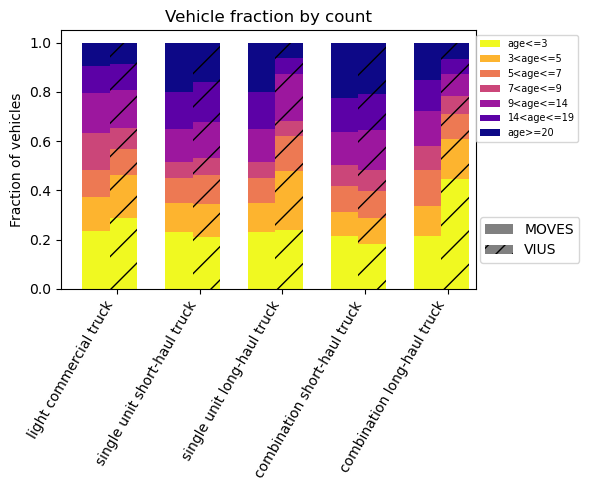

In [34]:
# normalized vehicle plot

vius_count_by_stmy.loc[:, age_bin_label] = \
    vius_count_by_stmy.loc[:, age_bin_label].div(vius_count_by_stmy.loc[:, age_bin_label].sum(axis=1), axis=0)

MOVES_count_by_stmy.loc[:, age_bin_label] = \
    MOVES_count_by_stmy.loc[:, age_bin_label].div(MOVES_count_by_stmy.loc[:, age_bin_label].sum(axis=1), axis=0)

plot_clustered_stacked([MOVES_count_by_stmy, vius_count_by_stmy],
                       ["MOVES", "VIUS"], 
                       'Vehicle fraction by count', 
                       'Fraction of vehicles')

plt.savefig('RawData/MOVES/plot/truck_frac_comparison_by_stmy.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

# Part 2.2 - truck type and age distribution by VMT

In [35]:
# compare veh VMT by MOVES source type and age bin
# plot ST MY distribution
# MOVES_fleet.head(5)
MOVES_fleet_selected = \
MOVES_fleet[['sourceTypeName', 'ageID', 'AGE_BIN', 
             'fuelTypeID', 'regClassID', 'vmt_fraction']]
MOVES_fleet_selected = \
MOVES_fleet_selected.drop_duplicates(keep = 'first')


MOVES_VMT_by_stmy = pd.pivot_table(MOVES_fleet_selected, 
                                   index = 'sourceTypeName',
                                  columns = 'AGE_BIN', 
                                   values = 'vmt_fraction',
                                  aggfunc = 'sum')

MOVES_VMT_by_stmy = MOVES_VMT_by_stmy.reset_index()
print(MOVES_VMT_by_stmy['sourceTypeName'].unique())
# MOVES_count_by_st

vius_VMT_by_stmy = \
vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN'])[['WGT_VMT']].sum()
vius_VMT_by_stmy = vius_VMT_by_stmy.reset_index()

vius_VMT_by_stmy.loc[:, 'vmt_fraction'] = \
vius_VMT_by_stmy.loc[:, 'WGT_VMT'] / \
vius_VMT_by_stmy.loc[:, 'WGT_VMT'].sum()
vius_VMT_by_stmy = pd.pivot_table(vius_VMT_by_stmy, 
                                  index = 'VEH_CLASS_MOVES',
                                  columns = 'AGE_BIN', 
                                  values = 'vmt_fraction',
                                  aggfunc = 'sum')
vius_VMT_by_stmy = vius_VMT_by_stmy.reset_index()
vius_VMT_by_stmy = \
vius_VMT_by_stmy.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})

vius_VMT_by_stmy = vius_VMT_by_stmy.set_index('sourceTypeName')
MOVES_VMT_by_stmy = MOVES_VMT_by_stmy.set_index('sourceTypeName')

vius_VMT_by_stmy.head(5)


['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


AGE_BIN,14<age<=19,3<age<=5,5<age<=7,7<age<=9,9<age<=14,age<=3,age>=20
sourceTypeName,,,,,,,
combination long-haul truck,0.008028,0.029503,0.016886,0.011642,0.014744,0.094506,0.008992
combination short-haul truck,0.005624,0.007151,0.006690,0.004810,0.007206,0.013375,0.005709
light commercial truck,0.045191,0.138026,0.081563,0.048894,0.083479,0.206544,0.020406
single unit long-haul truck,0.001532,0.005930,0.004211,0.002565,0.003650,0.007770,0.001845
single unit short-haul truck,0.013031,0.022597,0.014703,0.008231,0.014281,0.032895,0.007789


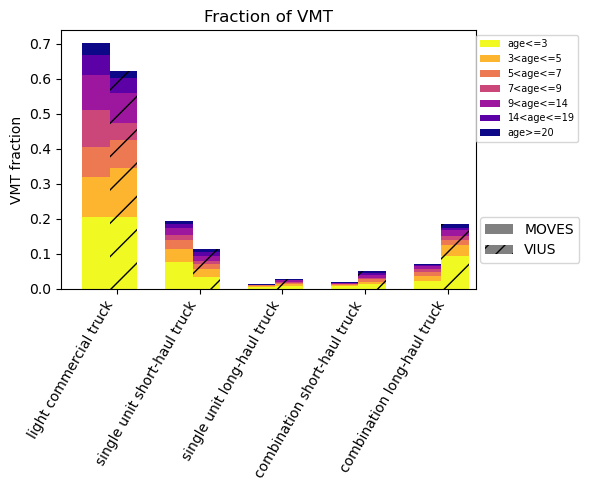

In [36]:
# plot stacked bar chart

vius_VMT_by_stmy = vius_VMT_by_stmy[age_bin_label]
vius_VMT_by_stmy = vius_VMT_by_stmy.loc[order_of_col]

MOVES_VMT_by_stmy = MOVES_VMT_by_stmy[age_bin_label]
MOVES_VMT_by_stmy = MOVES_VMT_by_stmy.loc[order_of_col]
plot_clustered_stacked([MOVES_VMT_by_stmy, vius_VMT_by_stmy],
                       ["MOVES", "VIUS"], 
                       'Fraction of VMT', 
                       'VMT fraction')

plt.savefig('RawData/MOVES/plot/truck_vmt_comparison_by_stmy.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

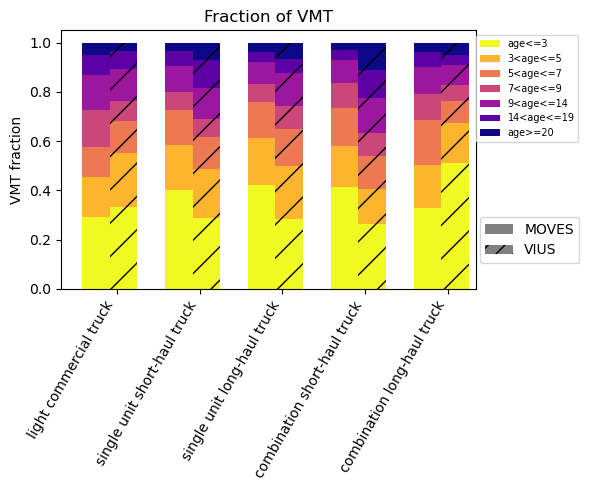

In [37]:
# plot normalized bar chart

vius_VMT_by_stmy.loc[:, age_bin_label] = \
    vius_VMT_by_stmy.loc[:, age_bin_label].div(vius_VMT_by_stmy.loc[:, age_bin_label].sum(axis=1), axis=0)

MOVES_VMT_by_stmy.loc[:, age_bin_label] = \
    MOVES_VMT_by_stmy.loc[:, age_bin_label].div(MOVES_VMT_by_stmy.loc[:, age_bin_label].sum(axis=1), axis=0)
plot_clustered_stacked([MOVES_VMT_by_stmy, vius_VMT_by_stmy],
                       ["MOVES", "VIUS"], 
                       'Fraction of VMT', 
                       'VMT fraction')

plt.savefig('RawData/MOVES/plot/truck_vmt_frac_comparison_by_stmy.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

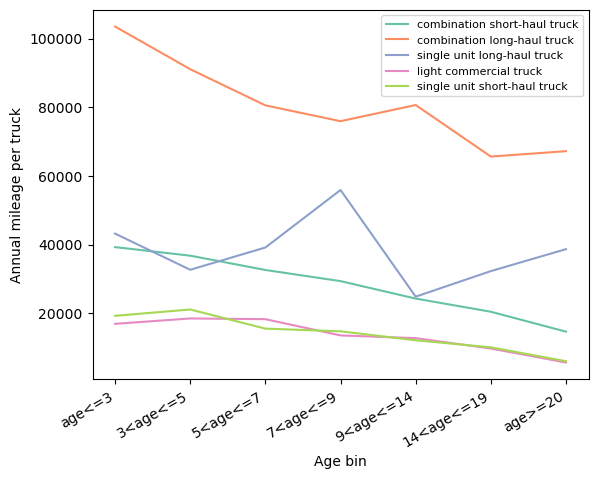

In [38]:
# VIUS VMT/truck

vius_stats_by_st_age = \
vius_fleet.groupby(['VEH_CLASS_MOVES', 'AGE_BIN'])[['TABWEIGHT','WGT_VMT']].sum()
vius_stats_by_st_age = vius_stats_by_st_age.reset_index()
vius_stats_by_st_age.loc[:, 'AGE_ORDER'] = \
vius_stats_by_st_age.loc[:, 'AGE_BIN'].map(age_bin_order)

vius_stats_by_st_age = \
vius_stats_by_st_age.sort_values(by = 'AGE_ORDER', ascending = True)

vius_stats_by_st_age.loc[:, 'ANNUAL_MILE_PER_TRUCK'] = \
vius_stats_by_st_age.loc[:, 'WGT_VMT'] / \
vius_stats_by_st_age.loc[:, 'TABWEIGHT']
sns.lineplot(vius_stats_by_st_age, 
            x="AGE_BIN", y="ANNUAL_MILE_PER_TRUCK", palette = 'Set2',
            hue="VEH_CLASS_MOVES", 
            errorbar = None)
plt.xticks(rotation = 30, ha= 'right')
plt.xlabel('Age bin')
plt.ylabel('Annual mileage per truck')
plt.legend(fontsize = 8, loc = 1)
plt.savefig('RawData/MOVES/plot/VIUS_VMT_per_truck_by_type_age.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

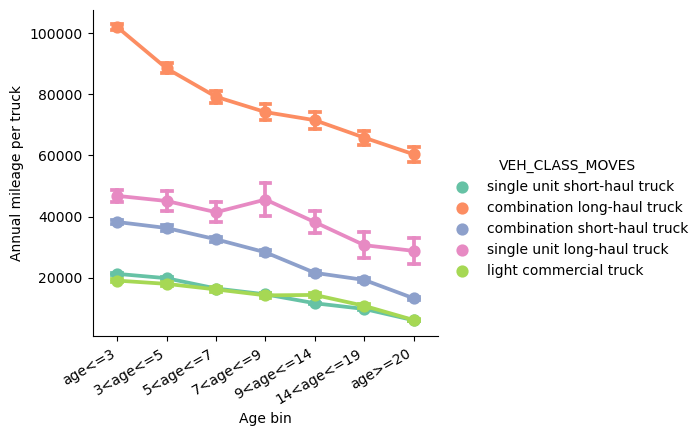

In [39]:
vius_fleet = \
vius_fleet.sort_values(by = 'VEH_AGE', ascending = True)
sns.catplot(x="AGE_BIN", y="MILESANNL",
             hue="VEH_CLASS_MOVES", 
             data=vius_fleet, capsize=.2, palette = 'Set2',
            errorbar="se", kind="point", height=4, aspect=1.25,)
plt.xticks(rotation = 30, ha= 'right')
plt.xlabel('Age bin')
plt.ylabel('Annual mileage per truck')
plt.savefig('RawData/MOVES/plot/VIUS_VMT_distribution_by_type_age.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

# Part 3.1 - truck type and fuel distribution by count

In [40]:

print(MOVES_fleet.fuelTypeID.unique())
# 1- gas, 2 - diesel, 3 - CNG, 5 - E-85, 9 - elec
print(vius_fleet.FUELTYPE.unique())

vius_fleet_with_fuel = \
vius_fleet.loc[vius_fleet['FUELTYPE'] != 'Not reported']
print(len(vius_fleet_with_fuel))
vius_fleet_with_fuel.loc[:, 'fuelTypeName'] = \
vius_fleet_with_fuel.loc[:, 'FUELTYPE'].map(VIUS_fuel_lookup)

MOVES_fleet.loc[:, 'fuelTypeName'] = \
MOVES_fleet.loc[:, 'fuelTypeID'].map(MOVES_fuel_lookup)

print(vius_fleet_with_fuel['fuelTypeName'].unique())
print(MOVES_fleet['fuelTypeName'].unique())

[1 2 5 9 3]
['Diesel' 'Gasoline' 'Not reported' 'Propane' 'Electricity'
 'Compressed natural gas' 'Combination' 'Liquified natural gas'
 'Alcohol fuels']
36311
['Diesel' 'Gasoline' 'Other' 'Electricity' 'CNG']
['Gasoline' 'Diesel' 'Other' 'Electricity' 'CNG']


In [41]:
# compare fuel type
# MOVES_fleet.loc[:, 'population_year_fuel'] = \
# MOVES_fleet.loc[:, 'population_by_year'] * MOVES_fleet.loc[:, 'stmyFraction']
MOVES_count_by_fuel = pd.pivot_table(MOVES_fleet, index = 'sourceTypeName',
                                  columns = 'fuelTypeName', values = 'population_by_year_class',
                                  aggfunc = 'sum')

MOVES_count_by_fuel = MOVES_count_by_fuel.reset_index()
print(MOVES_count_by_fuel['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_fuel = pd.pivot_table(vius_fleet_with_fuel, 
                                    index = 'VEH_CLASS_MOVES',
                                  columns = 'fuelTypeName', 
                                    values = 'TABWEIGHT',
                                  aggfunc = 'sum')
vius_count_by_fuel = vius_count_by_fuel.reset_index()

vius_count_by_fuel = \
vius_count_by_fuel.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})


vius_count_by_fuel = vius_count_by_fuel.set_index('sourceTypeName')
MOVES_count_by_fuel = MOVES_count_by_fuel.set_index('sourceTypeName')

vius_count_by_fuel.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


fuelTypeName,CNG,Diesel,Electricity,Gasoline,Other
sourceTypeName,,,,,
combination long-haul truck,4548.5,1044597.0,NaN,185.9,1472.0
combination short-haul truck,2892.8,941830.3,NaN,1714.0,2272.4
light commercial truck,NaN,1228920.7,24266.9,20370360.7,240884.0
single unit long-haul truck,696.5,278980.4,NaN,110842.7,565.9
single unit short-haul truck,22479.6,2699297.2,312.3,1365260.9,12535.6


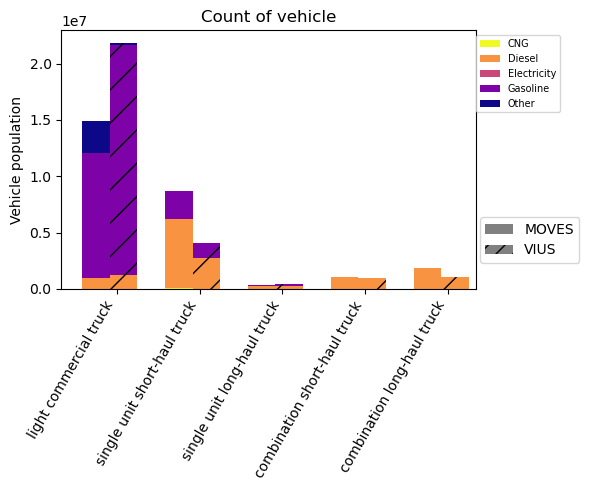

In [42]:

vius_count_by_fuel = vius_count_by_fuel.loc[order_of_col]

MOVES_count_by_fuel = MOVES_count_by_fuel.loc[order_of_col]
plot_clustered_stacked([MOVES_count_by_fuel, vius_count_by_fuel],
                       ["MOVES", "VIUS"], 
                       'Count of vehicle', 
                       'Vehicle population')

plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_fuel.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()


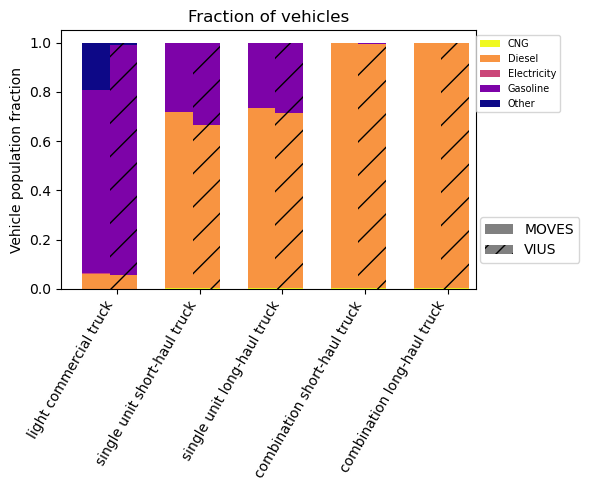

In [43]:
# plot normalized bar chart
fuel_types = vius_fleet_with_fuel['fuelTypeName'].unique()
vius_count_by_fuel.loc[:, fuel_types] = \
    vius_count_by_fuel.loc[:, fuel_types].div(vius_count_by_fuel.loc[:, fuel_types].sum(axis=1), axis=0)

MOVES_count_by_fuel.loc[:, fuel_types] = \
    MOVES_count_by_fuel.loc[:, fuel_types].div(MOVES_count_by_fuel.loc[:, fuel_types].sum(axis=1), axis=0)
plot_clustered_stacked([MOVES_count_by_fuel, vius_count_by_fuel],
                       ["MOVES", "VIUS"], 
                       'Fraction of vehicles', 
                       'Vehicle population fraction')

plt.savefig('RawData/MOVES/plot/truck_frac_comparison_by_fuel.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

# Part 3.2 - truck type and fuel distribution by VMT

In [44]:
# VMT by fuel type

MOVES_VMT_by_fuel = pd.pivot_table(MOVES_fleet, 
                                   index = 'sourceTypeName',
                                  columns = 'fuelTypeName', 
                                   values = 'vmt_fraction',
                                  aggfunc = 'sum')

MOVES_VMT_by_fuel = MOVES_VMT_by_fuel.reset_index()
print(MOVES_VMT_by_fuel['sourceTypeName'].unique())
# MOVES_count_by_st

vius_VMT_by_fuel = \
vius_fleet_with_fuel.groupby(['VEH_CLASS_MOVES', 'fuelTypeName'])[['WGT_VMT']].sum()
vius_VMT_by_fuel = vius_VMT_by_fuel.reset_index()

vius_VMT_by_fuel.loc[:, 'vmt_fraction'] = \
vius_VMT_by_fuel.loc[:, 'WGT_VMT'] / \
vius_VMT_by_fuel.loc[:, 'WGT_VMT'].sum()
vius_VMT_by_fuel = pd.pivot_table(vius_VMT_by_fuel, 
                                  index = 'VEH_CLASS_MOVES',
                                  columns = 'fuelTypeName', 
                                  values = 'vmt_fraction',
                                  aggfunc = 'sum')
vius_VMT_by_fuel = vius_VMT_by_fuel.reset_index()
vius_VMT_by_fuel = \
vius_VMT_by_fuel.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})

vius_VMT_by_fuel = vius_VMT_by_fuel.set_index('sourceTypeName')
MOVES_VMT_by_fuel = MOVES_VMT_by_fuel.set_index('sourceTypeName')

vius_VMT_by_fuel.head(5)


['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


fuelTypeName,CNG,Diesel,Electricity,Gasoline,Other
sourceTypeName,,,,,
combination long-haul truck,0.001057,0.183636,NaN,0.000019,0.000225
combination short-haul truck,0.000236,0.049487,NaN,0.000087,0.000082
light commercial truck,NaN,0.031518,0.000252,0.587388,0.006251
single unit long-haul truck,0.000042,0.020670,NaN,0.006978,0.000034
single unit short-haul truck,0.000870,0.075097,0.000014,0.035542,0.000516


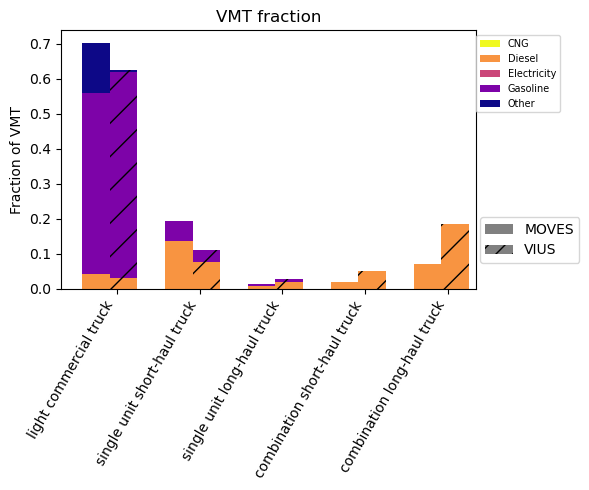

In [45]:
#plot fuel type distribution BY vmt


vius_VMT_by_fuel = vius_VMT_by_fuel.loc[order_of_col]

MOVES_VMT_by_fuel = MOVES_VMT_by_fuel.loc[order_of_col]
plot_clustered_stacked([MOVES_VMT_by_fuel, vius_VMT_by_fuel],
                       ["MOVES", "VIUS"], 
                       'VMT fraction', 
                       'Fraction of VMT')

plt.savefig('RawData/MOVES/plot/truck_VMT_comparison_by_fuel.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()


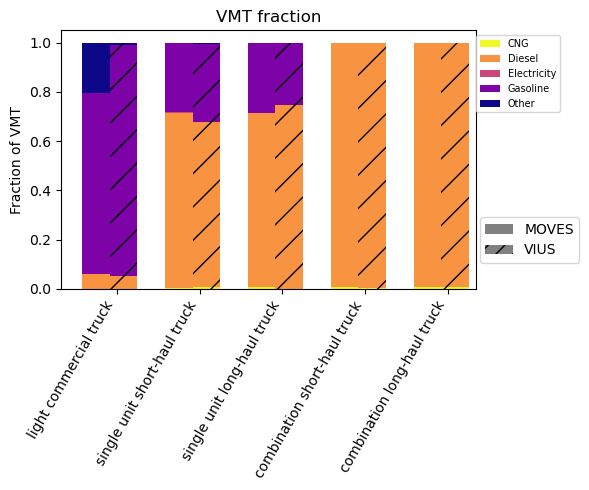

In [46]:
# plot normalized bar chart
fuel_types = vius_fleet_with_fuel['fuelTypeName'].unique()
vius_VMT_by_fuel.loc[:, fuel_types] = \
    vius_VMT_by_fuel.loc[:, fuel_types].div(vius_VMT_by_fuel.loc[:, fuel_types].sum(axis=1), axis=0)

MOVES_VMT_by_fuel.loc[:, fuel_types] = \
    MOVES_VMT_by_fuel.loc[:, fuel_types].div(MOVES_VMT_by_fuel.loc[:, fuel_types].sum(axis=1), axis=0)
plot_clustered_stacked([MOVES_VMT_by_fuel, vius_VMT_by_fuel],
                       ["MOVES", "VIUS"], 
                       'VMT fraction', 
                       'Fraction of VMT')

plt.savefig('RawData/MOVES/plot/truck_VMT_frac_comparison_by_fuel.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

# Part 4.1 - truck type and reg class distribution by count

In [47]:
# plot ST RegClass distribution
# MOVES_fleet.head(5)
MOVES_fleet_selected = \
MOVES_fleet[['sourceTypeName', 'ageID', 'AGE_BIN', 
             'fuelTypeID', 'regClassName', 'population_by_year_class']]
MOVES_fleet_selected = MOVES_fleet_selected.drop_duplicates(keep = 'first')


MOVES_count_by_streg = pd.pivot_table(MOVES_fleet_selected, index = 'sourceTypeName',
                                  columns = 'regClassName', values = 'population_by_year_class',
                                  aggfunc = 'sum')

MOVES_count_by_streg = MOVES_count_by_streg.reset_index()
print(MOVES_count_by_streg['sourceTypeName'].unique())
# MOVES_count_by_st

vius_count_by_streg = pd.pivot_table(vius_fleet, index = 'VEH_CLASS_MOVES',
                                  columns = 'regClassName', values = 'TABWEIGHT',
                                  aggfunc = 'sum')
vius_count_by_streg = vius_count_by_streg.reset_index()

vius_count_by_streg = \
vius_count_by_streg.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})

vius_count_by_streg = vius_count_by_streg.set_index('sourceTypeName')
vius_count_by_streg = vius_count_by_streg.fillna(0)
MOVES_count_by_streg = MOVES_count_by_streg.set_index('sourceTypeName')
MOVES_count_by_streg = MOVES_count_by_streg.fillna(0)
vius_count_by_streg.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


regClassName,HHD8 (w. glider),LDT,LHD2b3,LHD45,MHD67
sourceTypeName,,,,,
combination long-haul truck,1029327.2,0.0,0.0,0.0,28665.9
combination short-haul truck,886010.6,0.0,0.0,0.0,82628.2
light commercial truck,0.0,17614103.3,4480726.8,0.0,0.0
single unit long-haul truck,50393.0,0.0,197415.3,59300.9,85788.7
single unit short-haul truck,635832.6,0.0,1724369.2,953546.8,864006.7


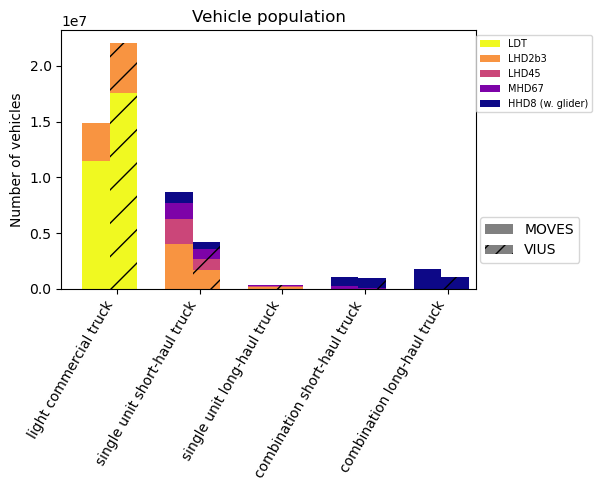

In [48]:
# plot stacked bar chart

vius_count_by_streg = vius_count_by_streg[order_of_reg]
vius_count_by_streg = vius_count_by_streg.loc[order_of_col]

MOVES_count_by_streg = MOVES_count_by_streg[order_of_reg]
MOVES_count_by_streg = MOVES_count_by_streg.loc[order_of_col]
plot_clustered_stacked([MOVES_count_by_streg, vius_count_by_streg],
                       ["MOVES", "VIUS"], 
                       'Vehicle population', 
                       'Number of vehicles')

plt.savefig('RawData/MOVES/plot/truck_count_comparison_by_streg.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

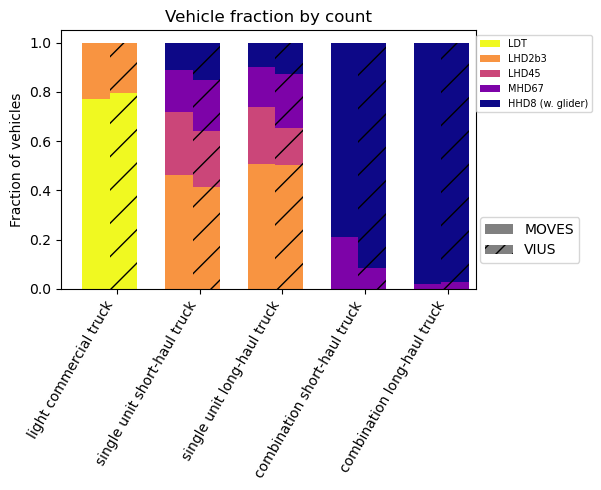

In [49]:
# normalized vehicle plot

vius_count_by_streg.loc[:, order_of_reg] = \
    vius_count_by_streg.loc[:, order_of_reg].div(vius_count_by_streg.loc[:, order_of_reg].sum(axis=1), axis=0)

MOVES_count_by_streg.loc[:, order_of_reg] = \
    MOVES_count_by_streg.loc[:, order_of_reg].div(MOVES_count_by_streg.loc[:, order_of_reg].sum(axis=1), axis=0)

plot_clustered_stacked([MOVES_count_by_streg, vius_count_by_streg],
                       ["MOVES", "VIUS"], 
                       'Vehicle fraction by count', 
                       'Fraction of vehicles')

plt.savefig('RawData/MOVES/plot/truck_frac_comparison_by_streg.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

In [50]:
# compare veh VMT by MOVES source type and reg class
# plot ST MY distribution
# MOVES_fleet.head(5)
MOVES_fleet_selected = \
MOVES_fleet[['sourceTypeName', 'ageID', 'AGE_BIN', 
             'fuelTypeID', 'regClassName', 'vmt_fraction']]
MOVES_fleet_selected = \
MOVES_fleet_selected.drop_duplicates(keep = 'first')


MOVES_VMT_by_streg = pd.pivot_table(MOVES_fleet_selected, 
                                   index = 'sourceTypeName',
                                  columns = 'regClassName', 
                                   values = 'vmt_fraction',
                                  aggfunc = 'sum')

MOVES_VMT_by_streg = MOVES_VMT_by_streg.reset_index()
print(MOVES_VMT_by_streg['sourceTypeName'].unique())
# MOVES_count_by_st

vius_VMT_by_streg = \
vius_fleet.groupby(['VEH_CLASS_MOVES', 'regClassName'])[['WGT_VMT']].sum()
vius_VMT_by_streg = vius_VMT_by_streg.reset_index()

vius_VMT_by_streg.loc[:, 'vmt_fraction'] = \
vius_VMT_by_streg.loc[:, 'WGT_VMT'] / \
vius_VMT_by_streg.loc[:, 'WGT_VMT'].sum()
vius_VMT_by_streg = pd.pivot_table(vius_VMT_by_streg, 
                                  index = 'VEH_CLASS_MOVES',
                                  columns = 'regClassName', 
                                  values = 'vmt_fraction',
                                  aggfunc = 'sum')
vius_VMT_by_streg = vius_VMT_by_streg.reset_index()
vius_VMT_by_streg = \
vius_VMT_by_streg.rename(columns = {'VEH_CLASS_MOVES': 'sourceTypeName'})

vius_VMT_by_streg = vius_VMT_by_streg.set_index('sourceTypeName')
MOVES_VMT_by_streg = MOVES_VMT_by_streg.set_index('sourceTypeName')

vius_VMT_by_streg.head(5)

['combination long-haul truck' 'combination short-haul truck'
 'light commercial truck' 'single unit long-haul truck'
 'single unit short-haul truck']


regClassName,HHD8 (w. glider),LDT,LHD2b3,LHD45,MHD67
sourceTypeName,,,,,
combination long-haul truck,0.179027,NaN,NaN,NaN,0.005274
combination short-haul truck,0.047281,NaN,NaN,NaN,0.003284
light commercial truck,NaN,0.500356,0.123747,NaN,NaN
single unit long-haul truck,0.005761,NaN,0.010182,0.004346,0.007214
single unit short-haul truck,0.019304,NaN,0.046943,0.024378,0.022902


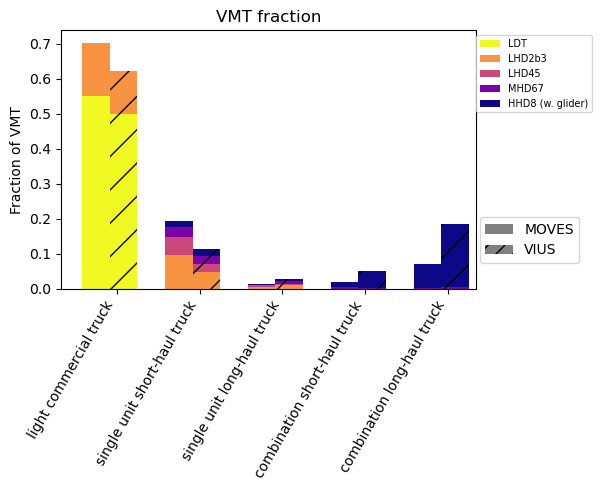

In [51]:
# plot stacked bar chart

vius_VMT_by_streg = vius_VMT_by_streg[order_of_reg]
vius_VMT_by_streg = vius_VMT_by_streg.loc[order_of_col]

MOVES_VMT_by_streg = MOVES_VMT_by_streg[order_of_reg]
MOVES_VMT_by_streg = MOVES_VMT_by_streg.loc[order_of_col]
plot_clustered_stacked([MOVES_VMT_by_streg, vius_VMT_by_streg],
                       ["MOVES", "VIUS"], 
                       'VMT fraction', 
                       'Fraction of VMT')

plt.savefig('RawData/MOVES/plot/truck_vmt_comparison_by_streg.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()

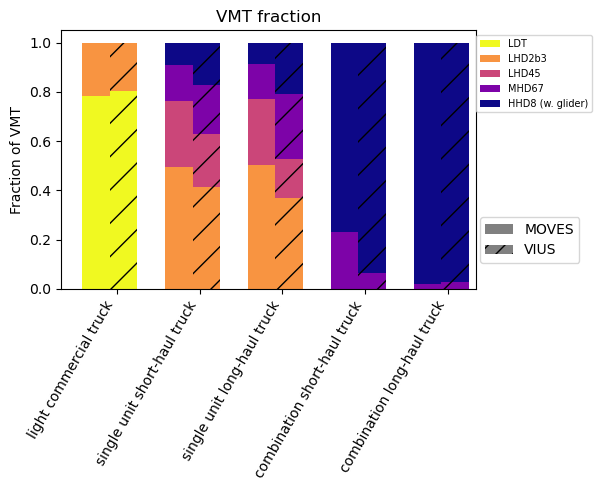

In [52]:
# normalized vehicle plot

vius_VMT_by_streg.loc[:, order_of_reg] = \
    vius_VMT_by_streg.loc[:, order_of_reg].div(vius_VMT_by_streg.loc[:, order_of_reg].sum(axis=1), axis=0)

MOVES_VMT_by_streg.loc[:, order_of_reg] = \
    MOVES_VMT_by_streg.loc[:, order_of_reg].div(MOVES_VMT_by_streg.loc[:, order_of_reg].sum(axis=1), axis=0)

plot_clustered_stacked([MOVES_VMT_by_streg, vius_VMT_by_streg],
                       ["MOVES", "VIUS"], 
                       'VMT fraction', 
                       'Fraction of VMT')

plt.savefig('RawData/MOVES/plot/truck_vmt_frac_comparison_by_streg.png',
            dpi = 300, bbox_inches = 'tight')
plt.show()